In [13]:
import cv2
import mediapipe as mp
# mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [11]:
!pip install --upgrade mediapipe

20220720_203458
running on CPU on 4 cores
Model loaded successfully


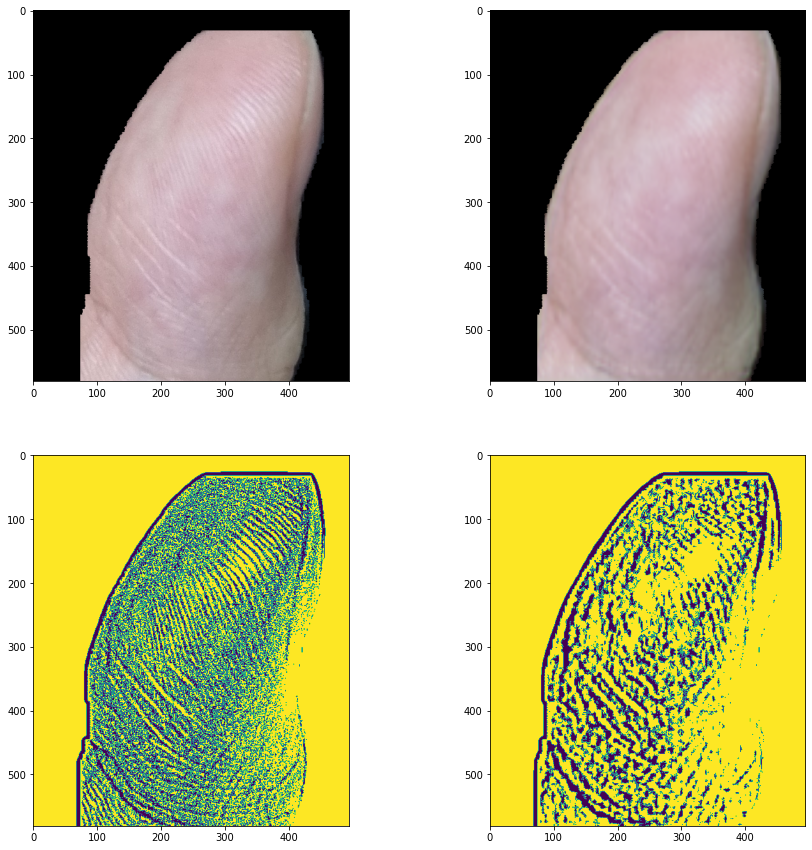

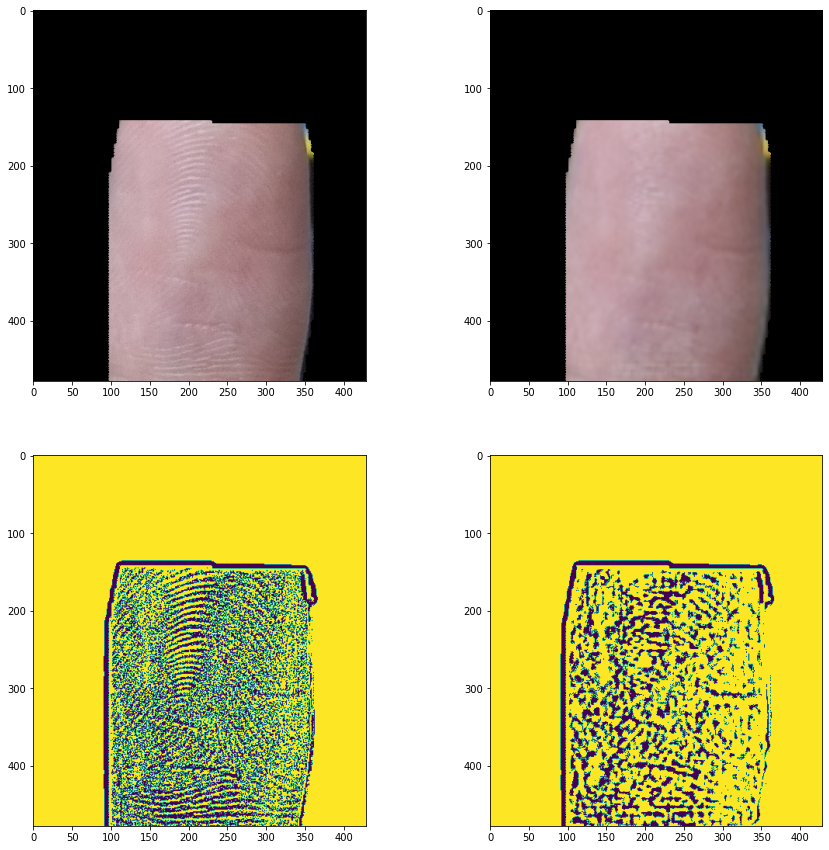

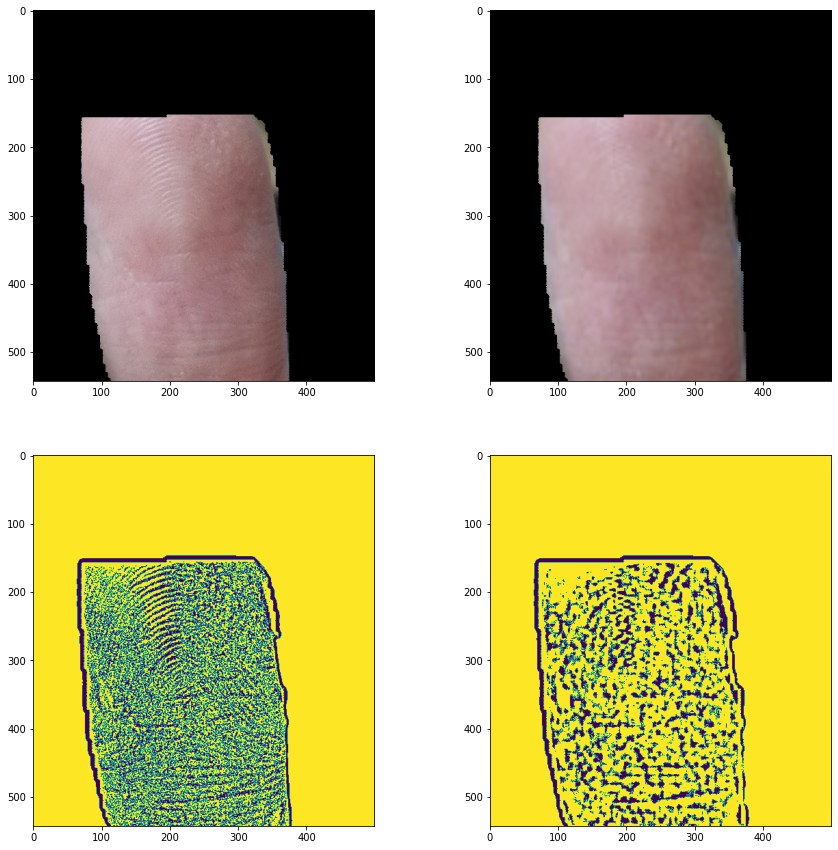

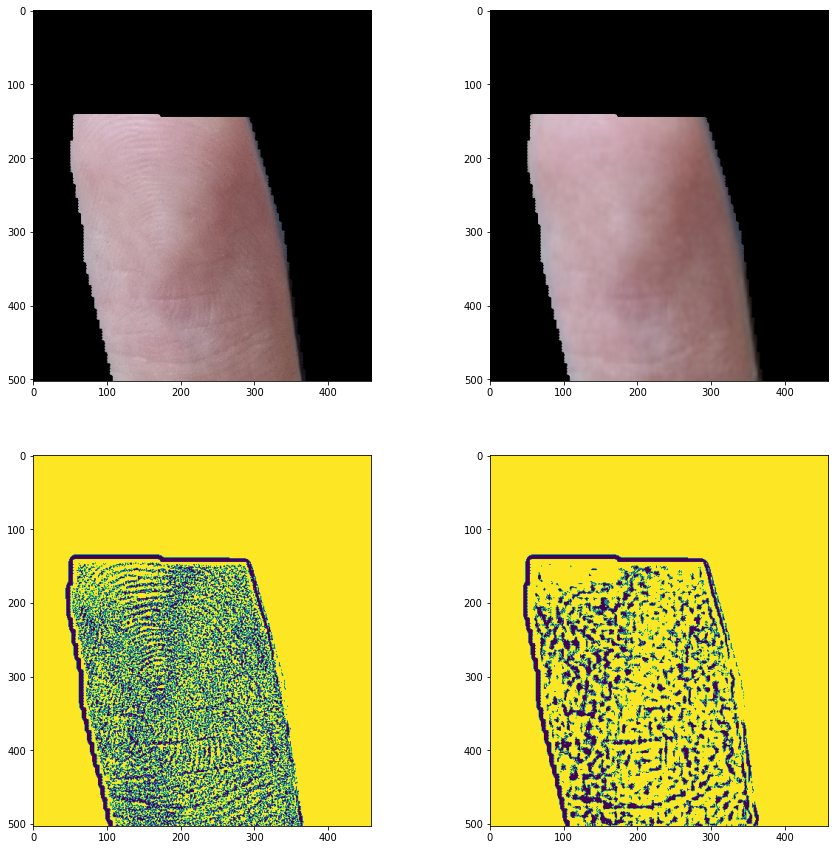

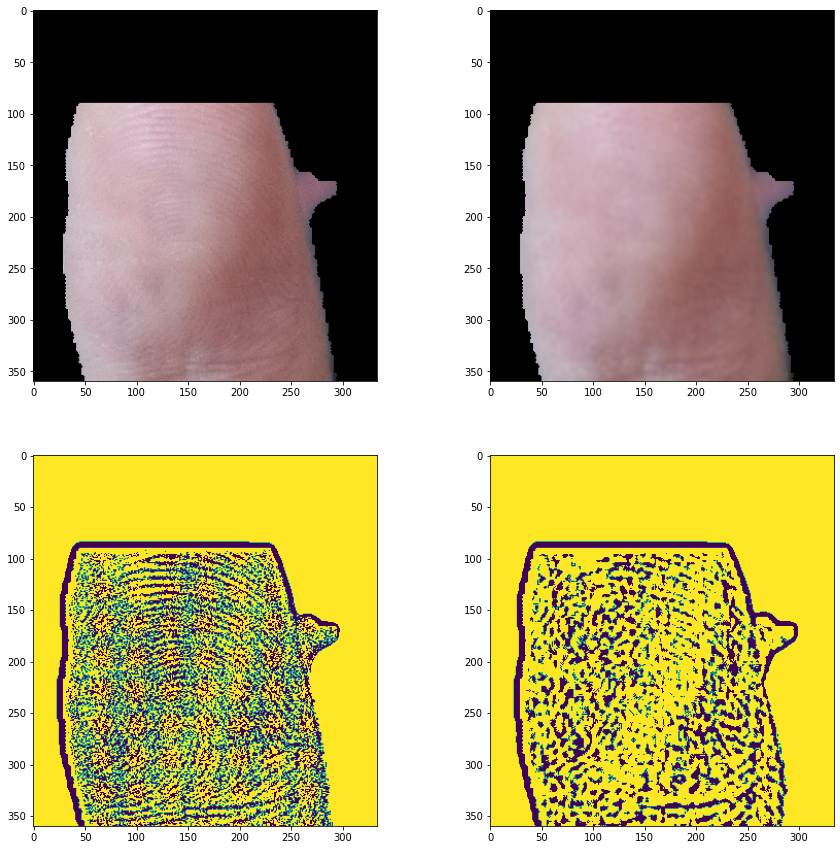

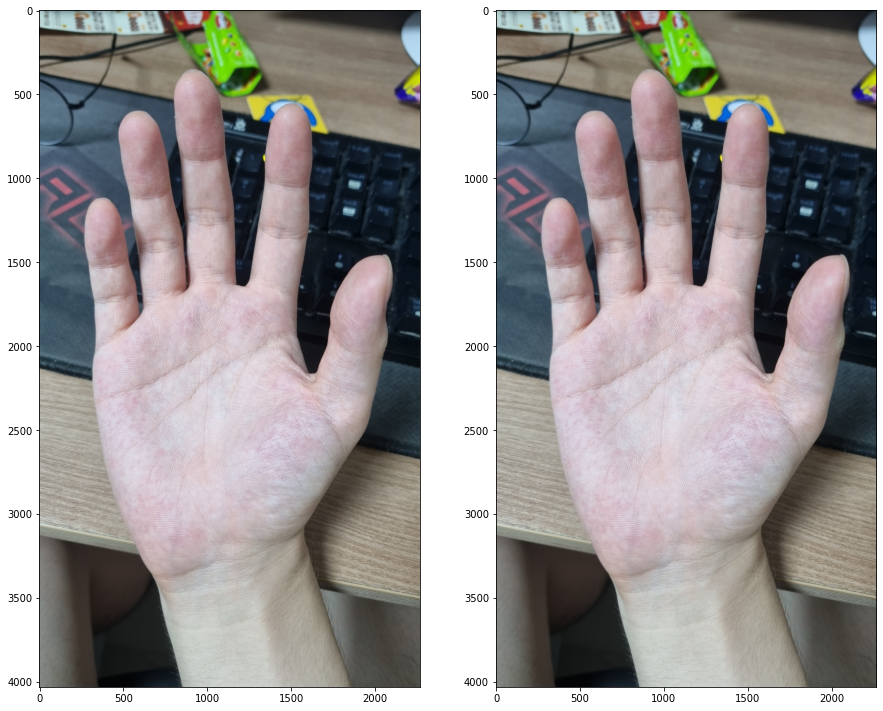

In [224]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from torchmodel import TorchModel
import tensorflow as tf
import io
import cv2
import requests
from PIL import Image
from requests_toolbelt.multipart.encoder import MultipartEncoder

IMAGE_FILES = glob('D:/project/your_fingerprints_are_precious/test_samples/*.jpg')
dst_path = 'D:/project/your_fingerprints_are_precious/test_samples/'

def enhance_fingerprint(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)
    ret, img = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
    return img

def expand_vector(coord1, coord2, is_thumb=False):
    x = coord2[0] - coord1[0]
    y = coord2[1] - coord1[1]
    vector = np.sqrt(x**2 + y**2)
    theta = np.arctan(np.abs(y/x))

    if x >= 0 and y >= 0:
        theta = theta
    elif x < 0 and y > 0:
        theta = np.pi - theta
    elif x < 0 and y < 0:
        theta = np.pi + theta
    else:
        theta = 2 * np.pi - theta

    if not is_thumb:
        expand_vector_x = 0.5 * vector * np.cos(theta)
        expand_vector_y = 0.5 * vector * np.sin(theta)
    else:
        expand_vector_x = 0.25 * vector * np.cos(theta)
        expand_vector_y = 0.25 * vector * np.sin(theta)

    return int(coord2[0] + expand_vector_x), int(coord2[1] + expand_vector_y)

def get_box(coord1, coord2):
    x = coord2[0] - coord1[0]
    y = coord2[1] - coord1[1]
    vector = np.sqrt(x**2 + y**2)
    theta = np.arctan(np.abs(y/x))

    x = list()
    y = list()
    x.append(coord1[0] + 0.5 * vector * np.cos(theta + 90 * np.pi / 180))
    x.append(coord1[0] + 0.5 * vector * np.cos(theta + 270 * np.pi / 180))
    x.append(coord2[0] + 0.25 * vector * np.cos(theta + 90 * np.pi / 180))
    x.append(coord2[0] + 0.25 * vector * np.cos(theta + 270 * np.pi / 180))

    y.append(coord1[1] + 0.5 * vector * np.sin(theta + 90 * np.pi / 180))
    y.append(coord1[1] + 0.5 * vector * np.sin(theta + 270 * np.pi / 180))
    y.append(coord2[1] + 0.25 * vector * np.sin(theta + 90 * np.pi / 180))
    y.append(coord2[1] + 0.25 * vector * np.sin(theta + 270 * np.pi / 180))

    x_min, x_max, y_min, y_max = map(int, (min(x), max(x), min(y), max(y)))

    return (x_min, y_max), (x_max, y_min)



for idx, file in enumerate(IMAGE_FILES):
    file = file.replace('\\', '/')
    fingertip_coordinates = list()
    with mp_hands.Hands(static_image_mode=True, max_num_hands=4, min_detection_confidence=0.3) as hands:
        image = cv2.flip(cv2.imread(file), 1)
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        file_name = file.split('/')[-1].split('.')[0]
        print(file_name)
        
        try:
            os.mkdir(f'D:/project/your_fingerprints_are_precious/test_samples/{file_name}')
            shutil.move(file, f'D:/project/your_fingerprints_are_precious/test_samples/{file_name}/{file_name}.jpg')
        except:
            shutil.move(f'D:/project/your_fingerprints_are_precious/test_samples/{file_name}/{file_name}.jpg', file)
            shutil.rmtree('D:/project/your_fingerprints_are_precious/test_samples/'+file_name)
            os.mkdir('D:/project/your_fingerprints_are_precious/test_samples/'+file_name)
            shutil.move(file, f'D:/project/your_fingerprints_are_precious/test_samples/{file_name}/{file_name}.jpg')
    
        if not results.multi_hand_landmarks:
            continue

        image_height, image_width, _ = image.shape

        for hand_landmarks in results.multi_hand_landmarks:
            thumb_ip = (hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].y * image_height)
            thumb_tip = (hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y * image_height)

            expand_thumb = expand_vector(thumb_ip, thumb_tip, is_thumb=True)
            coord1, coord2 = get_box(thumb_ip, expand_thumb)
            fingertip_coordinates.append((coord1, coord2))

            cropped_image = image[coord2[1]:coord1[1], coord1[0]:coord2[0]]
            try:
                cv2.imwrite(f"{dst_path}{file_name}/thumb.png", cv2.flip(cropped_image, 1))
            except:
                pass

            index_dip = (hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_height)
            index_tip = (hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height)

            expand_index = expand_vector(index_dip, index_tip)
            coord1, coord2 = get_box(index_dip, expand_index)
            fingertip_coordinates.append((coord1, coord2))

            cropped_image = image[coord2[1]:coord1[1], coord1[0]:coord2[0]]
            try:
                cv2.imwrite(f"{dst_path}{file_name}/index.png", cv2.flip(cropped_image, 1))
            except:
                pass

            middle_dip = (hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_DIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_DIP].y * image_height)
            middle_tip = (hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y * image_height)

            expand_middle = expand_vector(middle_dip, middle_tip)
            coord1, coord2 = get_box(middle_dip, expand_middle)
            fingertip_coordinates.append((coord1, coord2))

            cropped_image = image[coord2[1]:coord1[1], coord1[0]:coord2[0]]
            try:
                cv2.imwrite(f"{dst_path}{file_name}/middle.png", cv2.flip(cropped_image, 1))
            except:
                pass

            ring_dip = (hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_DIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_DIP].y * image_height)
            ring_tip = (hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y * image_height)

            expand_ring = expand_vector(ring_dip, ring_tip)
            coord1, coord2 = get_box(ring_dip, expand_ring)
            fingertip_coordinates.append((coord1, coord2))

            cropped_image = image[coord2[1]:coord1[1], coord1[0]:coord2[0]]
            try:
                cv2.imwrite(f"{dst_path}{file_name}/ring.png", cv2.flip(cropped_image, 1))
            except:
                pass

            pinky_dip = (hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_DIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_DIP].y * image_height)
            pinky_tip = (hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].x * image_width, hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y * image_height)

            expand_pinky = expand_vector(pinky_dip, pinky_tip)
            coord1, coord2 = get_box(pinky_dip, expand_pinky)
            fingertip_coordinates.append((coord1, coord2))

            cropped_image = image[coord2[1]:coord1[1], coord1[0]:coord2[0]]
            try:
                cv2.imwrite(f"{dst_path}{file_name}/pinky.png", cv2.flip(cropped_image, 1))
            except:
                pass


    efnet = TorchModel(
            model=(r"D:\project\your_fingerprints_are_precious\efficientnet-b3.trch"),
            out_chan=2,
            gpu=False,
            cpu_cores=4)

    fingers = list()
    fingers.append(f"{dst_path}{file_name}/thumb.png")
    fingers.append(f"{dst_path}{file_name}/index.png")
    fingers.append(f"{dst_path}{file_name}/middle.png")
    fingers.append(f"{dst_path}{file_name}/ring.png")
    fingers.append(f"{dst_path}{file_name}/pinky.png")

    manipulated_image = image.copy()

    for finger, fingertip_coordinate in zip(fingers, fingertip_coordinates):
        img = cv2.imread(finger)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        img = np.array(img)

        cls_prediction = efnet.predict(img / 255.0)
        
#         print(cls_prediction)
#         if cls_prediction[0]:
        if True:
            # Load Image with PIL
            pilImage = Image.fromarray(img)

            # Convert to JPEG Buffer
            buffered = io.BytesIO()
            pilImage.save(buffered, quality=100, format="JPEG")

            # Build multipart form and post request
            m = MultipartEncoder(fields={'file': ("imageToUpload", buffered.getvalue(), "image/jpeg")})

            response = requests.post("https://outline.roboflow.com/intel_global/2?api_key=ts0mcOhGkAfuUVKUFjvv", data=m, headers={'Content-Type': m.content_type})
            
            try:
                seg_coordinate = list()
                mask = np.zeros((img.shape), np.uint8)
                
                for coord in response.json()['predictions'][0]['points']:
                    x, y = int(coord['x']), int(coord['y'])
                    seg_coordinate.append([x, y])
                
                mask = cv2.fillConvexPoly(mask, np.array(seg_coordinate), (255, 255, 255)) // 255
                
                u_net = tf.keras.models.load_model("./u-net.h5")
                unet_prediction = u_net.predict(img.reshape((1, 128, 128, 3))/255.0).reshape((128, 128, 3))
                coord1, coord2 = fingertip_coordinate
                unet_prediction = cv2.resize(unet_prediction, (np.abs(coord1[0]-coord2[0]), np.abs(coord1[1]-coord2[1])))
                mask = cv2.flip(cv2.resize(mask, (np.abs(coord1[0]-coord2[0]), np.abs(coord1[1]-coord2[1]))), 1)
                unet_prediction = np.array(cv2.flip(unet_prediction, 1) * 255.0).astype(np.uint8)
                
                f, ax = plt.subplots(2, 2)
                f.set_figheight(15)
                f.set_figwidth(15)
                ax[0, 0].imshow(manipulated_image[coord2[1]:coord1[1], coord1[0]:coord2[0]][:,:,::-1] * mask)
                ax[0, 1].imshow(unet_prediction * mask)
                ax[1, 0].imshow(enhance_fingerprint(manipulated_image[coord2[1]:coord1[1], coord1[0]:coord2[0]] * mask))
                ax[1, 1].imshow(enhance_fingerprint(unet_prediction * mask))
                
                manipulated_image[coord2[1]:coord1[1], coord1[0]:coord2[0]] = manipulated_image[coord2[1]:coord1[1], coord1[0]:coord2[0]] * (mask^1) + unet_prediction[:,:,::-1] * mask
    
                
            except:
                u_net = tf.keras.models.load_model("./u-net.h5")
                unet_prediction = u_net.predict(img.reshape((1, 128, 128, 3))).reshape((128, 128, 3))
                coord1, coord2 = fingertip_coordinate
                unet_prediction = cv2.resize(unet_prediction, (np.abs(coord1[0]-coord2[0]), np.abs(coord1[1]-coord2[1])))
                unet_prediction = np.array(cv2.flip(unet_prediction, 1) * 255.0).astype(np.uint8)
            
                f, ax = plt.subplots(2, 2)
                f.set_figheight(15)
                f.set_figwidth(15)
                ax[0, 0].imshow(manipulated_image[coord2[1]:coord1[1], coord1[0]:coord2[0]][:,:,::-1])
                ax[0, 1].imshow(unet_prediction[:,:,::-1])
                ax[1, 0].imshow(enhance_fingerprint(manipulated_image[coord2[1]:coord1[1], coord1[0]:coord2[0]]))
                ax[1, 1].imshow(enhance_fingerprint(unet_prediction))
                
                manipulated_image[coord2[1]:coord1[1], coord1[0]:coord2[0]] = unet_prediction
            

    f, ax = plt.subplots(1, 2)
    f.set_figheight(15)
    f.set_figwidth(15)
    ax[0].imshow(image[:,:,::-1])
    ax[1].imshow(manipulated_image[:,:,::-1])
    plt.show()

In [171]:
import io
import cv2
import requests
from PIL import Image
from requests_toolbelt.multipart.encoder import MultipartEncoder

# Load Image with PIL
img = cv2.imread(r"D:\project\your_fingerprints_are_precious\test_samples\20220721_084854\middle.png")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pilImage = Image.fromarray(image)

# Convert to JPEG Buffer
buffered = io.BytesIO()
pilImage.save(buffered, quality=100, format="JPEG")

# Build multipart form and post request
m = MultipartEncoder(fields={'file': ("imageToUpload", buffered.getvalue(), "image/jpeg")})

response = requests.post("https://outline.roboflow.com/intel_global/2?api_key=ts0mcOhGkAfuUVKUFjvv", data=m, headers={'Content-Type': m.content_type})

print(response)
print(response.json())

<Response [200]>
{'predictions': [{'x': 263.6, 'y': 335.8, 'width': 415, 'height': 522, 'class': 'Fingerprints', 'confidence': 1.0, 'points': [{'x': 103.9, 'y': 596.0}, {'x': 99.0, 'y': 584.0}, {'x': 100.0, 'y': 571.0}, {'x': 98.0, 'y': 568.1}, {'x': 85.0, 'y': 563.1}, {'x': 68.0, 'y': 564.0}, {'x': 58.0, 'y': 562.1}, {'x': 56.0, 'y': 560.0}, {'x': 56.0, 'y': 506.0}, {'x': 62.7, 'y': 490.0}, {'x': 62.9, 'y': 480.0}, {'x': 66.6, 'y': 472.0}, {'x': 67.0, 'y': 465.0}, {'x': 69.7, 'y': 461.0}, {'x': 70.0, 'y': 452.0}, {'x': 77.6, 'y': 435.0}, {'x': 77.9, 'y': 426.0}, {'x': 84.7, 'y': 411.0}, {'x': 86.0, 'y': 403.0}, {'x': 88.7, 'y': 400.0}, {'x': 89.0, 'y': 395.0}, {'x': 91.8, 'y': 392.0}, {'x': 92.8, 'y': 382.0}, {'x': 95.7, 'y': 379.0}, {'x': 96.9, 'y': 373.0}, {'x': 99.7, 'y': 370.0}, {'x': 99.8, 'y': 365.0}, {'x': 103.7, 'y': 359.0}, {'x': 104.0, 'y': 355.0}, {'x': 106.7, 'y': 352.0}, {'x': 108.0, 'y': 342.0}, {'x': 109.8, 'y': 341.0}, {'x': 121.7, 'y': 314.0}, {'x': 122.9, 'y': 304.0}

In [178]:
coordinate = list()

mask = np.zeros((image.shape), np.uint8)

for coord in response.json()['predictions'][0]['points']:
    x, y = int(coord['x']), int(coord['y'])
    coordinate.append([x, y])

mask = cv2.fillConvexPoly(mask, np.array(coordinate), (255, 255, 255)) // 255

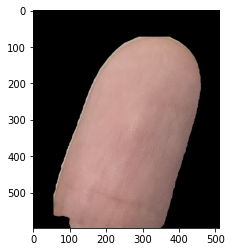

In [181]:
plt.imshow(mask * image)

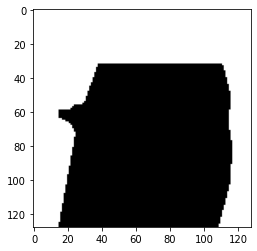

In [196]:
plt.imshow((mask ^ 1)*255)